In [1]:
#sambungkan ke google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split #library untuk train test
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif #library untuk koreksi nilai vif
from statsmodels.tools.tools import add_constant #library untuk koreksi nilai vif

In [3]:
# load dataset
data = pd.read_csv('/content/drive/MyDrive/GOOGLE COLAB/admit-data.csv')
data.head()

,gre_score,toefl_score,univ_ranking,motiv_letter_strength,recommendation_strength,gpa,research_exp,admit_prob
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


**PRE - PROCESSING**

In [4]:
#cek missing value
data.isna().sum() * 100 / len(data)

gre_score                  0.0
toefl_score                0.0
univ_ranking               0.0
motiv_letter_strength      0.0
recommendation_strength    0.0
gpa                        0.0
research_exp               0.0
admit_prob                 0.0
dtype: float64

In [5]:
#cek duplikat data
data.duplicated().sum()

0

*tidak terdapat missing value dan duplikat data*

**MULTI LINEAR REGRESSION**

In [6]:
#deskrip fitur dan target
X = data.drop(columns='admit_prob')
y = data[['admit_prob']]

#deskrip variabel train dan test
Xfitur_train, Xfitur_test, ytarget_train, ytarget_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
#cek nilai multicolinearity dengan variance inflation factor (VIF)
nilai = add_constant(Xfitur_train)

VIF = pd.DataFrame([vif(nilai.values, i) 
               for i in range(nilai.shape[1])], 
              index=nilai.columns).reset_index()
VIF.columns = ['X','vif_score']
VIF = VIF.loc[VIF.X!='const']
VIF


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,X,vif_score
1,gre_score,4.489983
2,toefl_score,3.664298
3,univ_ranking,2.572110
4,motiv_letter_strength,2.785764
5,recommendation_strength,1.977698
6,gpa,4.654540
7,research_exp,1.518065


Terdapat 2 fitur yang memiliki nilai vif_score terbesar, yaitu  :

**gre_score	4.489983**

**gpa	4.654540**

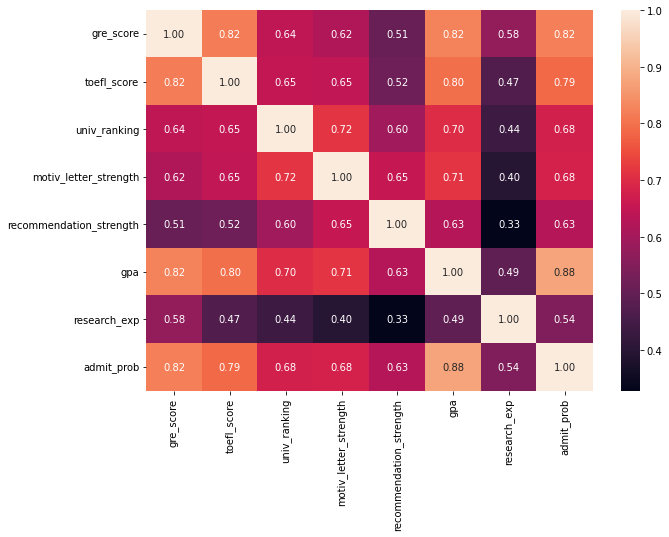

In [15]:
# lakukan pengecekan korelasi antar kolom (heatmap correlation)
data_train = pd.concat([Xfitur_train, ytarget_train], axis=1)
corr = data_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

Berdasarkan target yang sudah ditentukan (admit_prob), visualisasi menggunakan heatmap terdapat beberapa kolom yang memiliki hubungan yang erat : 

**gre_score - admit_prob nilai = 0.82**

**toefl_score - admit_prob nilai = 0.79**

**gpa - admit_prob nilai = 0.88**

Maka yang akan kita pertahankan yaitu **gpa - admit_prob** sisanya akan didrop

In [16]:
Xfitur_train = Xfitur_train.drop(columns=['gre_score','toefl_score']) 
Xfitur_test = Xfitur_test.drop(columns=['gre_score','toefl_score'])

In [17]:
#cek kembali nilai vif
nilai = add_constant(Xfitur_train)

VIF = pd.DataFrame([vif(nilai.values, i) 
               for i in range(nilai.shape[1])], 
              index=nilai.columns).reset_index()
VIF.columns = ['X','vif_score']
VIF = VIF.loc[VIF.X!='const']
VIF

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,X,vif_score
1,univ_ranking,2.511407
2,motiv_letter_strength,2.748278
3,recommendation_strength,1.965542
4,gpa,2.726281
5,research_exp,1.350514


**TRAINING MODEL**

In [19]:
from sklearn.linear_model import LinearRegression
# definisi model
multi_reg = LinearRegression()

# latih model
X_train = Xfitur_train.to_numpy()
y_train = ytarget_train.to_numpy()

multi_reg.fit(X_train, y_train)

LinearRegression()

In [20]:
data = Xfitur_train
model = multi_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_[0]] + list(model.coef_[0])
})

coef_df

,feature,coefficient
0,intercept,-0.766426
1,univ_ranking,0.006984
2,motiv_letter_strength,0.004346
3,recommendation_strength,0.014776
4,gpa,0.161004
5,research_exp,0.038274


admit_prob = -0.766 + 0.006 + 0.004 + 0.014 + 0.161 + 0.038

setiap pertambahan 1 nilai pada **GPA** dengan mengabaikan fitur lain maka akan menambah nilai admit_prob sebesar **0.161**

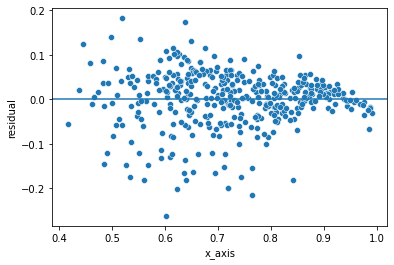

In [21]:
# calculate residuals
y_predict_train = multi_reg.predict(X_train)
residual = y_train - y_predict_train

#preprocess shape
y_predict_train = np.array([value for nested_array in y_predict_train for value in nested_array])
residual = np.array([value for nested_array in residual for value in nested_array])

# prepare dataframe
# >1 predictor --> predicted value VS residual
df_resid = pd.DataFrame({
    'x_axis': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="x_axis", y="residual")
plt.axhline(0)
plt.show()

Kesimpulan dari visualisasi scaterplot diatas adalah : 

Linear relationship terpenuhi oleh **garis lurus** terhadap **nilai residual**


**EVALUASI MODEL**

In [22]:
#train error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('R-squared for training data is {}'.format(r2_score(y_predict_train, y_train)))
print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_predict_train, y_train))))

R-squared for training data is 0.7479378982126861
RMSE for training data is 0.06298993296628584


Didapati hasil dengan data train mendapatkan nilai akurasi senilai **74.79 %**

In [24]:
#test error
X_admit_test = Xfitur_test.to_numpy()
y_predict_test = multi_reg.predict(X_admit_test)


y_admit_test = ytarget_test.to_numpy()

In [25]:
from sklearn.metrics import mean_squared_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_predict_test, y_admit_test))))

RMSE for testing data is 0.05880540869550099


Didapati hasil dengan data test mendapatkan nilai eror test sebesar **0.058 %** yang artinya memiliki tingkat eror yang rendah